# Microchip Classification Testing ipynb

In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os # directory
import seaborn as sns # plotting

from sklearn.metrics import confusion_matrix
from scipy import stats # mean calculation
from keras.utils.np_utils import to_categorical # to convert labels to one-hot-encoding
from PIL import Image

Using TensorFlow backend.


In [2]:
path = './test_images/'

def load_image(path):
    def readImg(path, n):
        im = Image.open(path).convert('L')
        im = im.resize((n,n))
        return np.array(im)/255.0

    all_images = []
    all_labels = []
    labels_dict = {}

    count = 0
    size = 27
    for label in os.listdir(path):
        second_path = path+str(label)+'/'
        for img_path in os.listdir(second_path):
            if img_path.endswith('.jpg'):
                im = readImg(second_path+img_path, size)
                all_images.append(im)
                all_labels.append(count)
        if (count < 3):
            labels_dict[count] = label
            count += 1
        elif (count == 3):
            labels_dict[count] = 'Unknown'

    all_images = np.reshape(all_images,(-1,27,27,1))

    # labels
    labels = np.reshape(all_labels, (-1,1))
    labels = to_categorical(labels, num_classes = 4) # Label Encoding 
    
    print('Imported Test Images of size ',all_images.shape,' and labels ',labels.shape)
    return all_images, labels, labels_dict

images, labels, n_classes= load_image(path)

Imported Test Images of size  (546, 27, 27, 1)  and labels  (546, 4)


In [3]:
class k_CNN():
    def __init__(self):
        self.models = []
        path = './models/a/'
        for count in range(1,11):
            model = tf.keras.models.load_model(path+'model_10_16_15_{}.h5'.format(count))
            self.models.append(model)
            
    def predict(self, X_test, Y_test):
        pred = []
        
        for model in self.models:
            # Predict the values from the validation dataset
            Y_pred = model.predict(X_test)
            # Convert predictions classes to one hot vectors 
            Y_pred_classes = np.argmax(Y_pred,axis = 1)
            
            pred.append(Y_pred_classes)

        pred = np.transpose(pred)
        pred , _ = stats.mode(pred, axis= 1)

        Y_pred = []
        for y in pred.tolist():
            for z in y:
                Y_pred.append(z)
                
        Y_true = np.argmax(Y_test,axis = 1)
            
        return Y_true, Y_pred
    
    def accuracy_test(self, Y_true, Y_pred):
        test_accuracy = np.mean(Y_true == Y_pred)
        return test_accuracy
    
    def plot_confusion(self, Y_true, Y_pred):
        confusion_mtx = confusion_matrix(Y_true, Y_pred) 
        # plot the confusion matrix
        f,ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        self.calculate_precision_recall(confusion_mtx)
    
    def calculate_precision_recall(self, confusion_mtx):
        sum_col = np.sum(confusion_mtx, axis = 0)
        sum_row = np.sum(confusion_mtx, axis = 1)
        result = []
        for n in range(len(n_classes)):
            TP = confusion_mtx[n][n]
            FN = sum_row[n]-TP
            FP = sum_col[n]-TP
            precision = TP/ (TP+FP)
            recall = TP / (TP+FN)
            f1score = 2 * ((precision*recall)/(precision+recall))
            result.append((n_classes[n],
                           precision,
                           recall,
                           f1score))
            print("\n{}:\nPrecision: {}\nRecall: {}\nF1 Score:{}\n".format(n_classes[n],
                                                                           precision,
                                                                           recall,
                                                                           f1score))
        df = pd.DataFrame(result, columns= ['class', 'precision', 'recall', 'f1score'])
        print(df)
        df.to_csv('./score{}.csv'.format(round(time.time())), index=False, header=True)
    
    def test(self, X_test, Y_test):
        Y_true, Y_pred = self.predict(X_test, Y_test)
        self.plot_confusion(Y_true, Y_pred)
        acc = self.accuracy_test(Y_true, Y_pred)
        print('\nTested overall accuracy: ',acc)
    
model = k_CNN()

## Show Testing Result

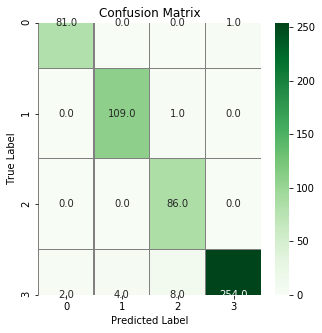


Capacitor:
Precision: 0.9759036144578314
Recall: 0.9878048780487805
F1 Score:0.9818181818181818


Resistor:
Precision: 0.9646017699115044
Recall: 0.990909090909091
F1 Score:0.9775784753363229


Sot:
Precision: 0.9052631578947369
Recall: 1.0
F1 Score:0.9502762430939227


Unknown:
Precision: 0.996078431372549
Recall: 0.9477611940298507
F1 Score:0.97131931166348

       class  precision    recall   f1score
0  Capacitor   0.975904  0.987805  0.981818
1   Resistor   0.964602  0.990909  0.977578
2        Sot   0.905263  1.000000  0.950276
3    Unknown   0.996078  0.947761  0.971319


NameError: name 'time' is not defined

In [4]:
model.test(images, labels)